# Исследовательский анализ данных (EDA)
## Датасет: Вакансии
## Содержание
1. [Введение](#1.-Введение)
2. [Загрузка данных](#2.-Загрузка-данных)
3. [Оценка структуры данных](#3.-Оценка-структуры-данных)
4. [Оценка целостности и полноты данных](#4.-Оценка-целостности-и-полноты-данных)
5. [Оценка выбросов и аномалий](#5.-Оценка-выбросов-и-аномалий)
6. [Заключение](#6.-Заключение)


## 1. Введение

### Цель анализа
Провести первичный исследовательский анализ датасета с вакансиями для оценки качества данных, выявления проблем и подготовки к дальнейшему анализу.

### О датасете
Датасет содержит информацию о вакансиях из различных источников, включая:
- Информацию о компаниях и позициях
- Географические данные
- Данные о датах публикации
- Категориальные признаки (тип работы, сектор)

In [198]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime

# Настройка отображения pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Библиотеки успешно загружены")
print(f"Pandas версия: {pd.__version__}")


Библиотеки успешно загружены
Pandas версия: 2.3.3


## 2. Загрузка данных

Загружаем датасет с Google Drive и выполняем первичную обработку типов данных.

In [199]:
# Загрузка данных
FILE_ID = "17jS24dobHhStIKS0M1m9kdGf4qST3r35"
file_url = f"https://drive.google.com/uc?export=download&id={FILE_ID}"

try:
    # Считываем CSV-файл
    raw_data = pd.read_csv(
        file_url,
        sep=",",
        quotechar='"',
        skipinitialspace=True,
        encoding="utf-8",
        on_bad_lines="skip"
    )

    print("✅ Датасет успешно загружен")
    print(f"📊 Размер датасета: {raw_data.shape[0]} строк, {raw_data.shape[1]} столбцов")

except Exception as e:
    print(f"❌ Ошибка при загрузке: {e}")
    raise


✅ Датасет успешно загружен
📊 Размер датасета: 22000 строк, 14 столбцов


In [200]:
# Первый взгляд на данные
print("Первые 5 строк датасета:")
raw_data.head()


Первые 5 строк датасета:


,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
0,United States of America,US,NaN,No,jobs.monster.com,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,NaN,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,United States of America,US,NaN,No,jobs.monster.com,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,NaN,e4cbb126dabf22159aff90223243ff2a
2,United States of America,US,NaN,No,jobs.monster.com,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,"Full Time, Employee",DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,http://jobview.monster.com/senior-training-lea...,NaN,NaN,839106b353877fa3d896ffb9c1fe01c0
3,United States of America,US,NaN,No,jobs.monster.com,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,NaN,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783
4,United States of America,US,NaN,No,jobs.monster.com,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,Full Time Employee,"Camphill, PA",Retail,http://jobview.monster.com/shift-supervisor-pa...,NaN,Project/Program Management,64d0272dc8496abfd9523a8df63c184c


In [201]:
# Приведение типов данных
df = raw_data.copy()

# Текстовые поля
text_cols = [
    "country", "country_code", "job_board", "job_title", "job_type",
    "location", "organization", "page_url", "sector", "uniq_id"
]

# Категориальные поля
category_cols = ["has_expired", "job_type", "sector"]

# Приведение текстовых полей
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype("string")

# Приведение категориальных полей
for col in category_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Числовые поля (зарплата)
if "salary" in df.columns:
    df["salary"] = pd.to_numeric(df["salary"], errors="coerce")

# Дата
if "date_added" in df.columns:
    df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

print("✅ Типы данных успешно приведены")


✅ Типы данных успешно приведены


## 3. Оценка структуры данных

Анализируем базовую структуру датасета: размерность, типы данных, названия столбцов.

In [202]:
# Базовая информация о структуре
print("="*70)
print("СТРУКТУРА ДАТАСЕТА")
print("="*70)
print(f"\n📐 Размерность датасета:")
print(f"   Количество строк: {df.shape[0]}")
print(f"   Количество столбцов: {df.shape[1]}")
print(f"   Общее количество ячеек: {df.shape[0] * df.shape[1]:,}")


СТРУКТУРА ДАТАСЕТА

📐 Размерность датасета:
   Количество строк: 22000
   Количество столбцов: 14
   Общее количество ячеек: 308,000


In [203]:
# Информация о типах данных
print("\n📊 Типы данных:")
print(df.dtypes)



📊 Типы данных:
country            string[python]
country_code       string[python]
date_added         datetime64[ns]
has_expired              category
job_board          string[python]
job_description            object
job_title          string[python]
job_type                 category
location           string[python]
organization       string[python]
page_url           string[python]
salary                    float64
sector                   category
uniq_id            string[python]
dtype: object


In [204]:
# Подсчет типов столбцов
type_counts = df.dtypes.value_counts()
print("\n📈 Распределение типов данных:")
print(type_counts)



📈 Распределение типов данных:
string[python]    8
datetime64[ns]    1
category          1
object            1
category          1
float64           1
category          1
Name: count, dtype: int64


In [205]:
# Список всех столбцов
print("\n📋 Список всех столбцов:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i}. {col} ({df[col].dtype})")



📋 Список всех столбцов:
   1. country (string)
   2. country_code (string)
   3. date_added (datetime64[ns])
   4. has_expired (category)
   5. job_board (string)
   6. job_description (object)
   7. job_title (string)
   8. job_type (category)
   9. location (string)
   10. organization (string)
   11. page_url (string)
   12. salary (float64)
   13. sector (category)
   14. uniq_id (string)


In [206]:
# Метрики структуры
print("\n" + "="*70)
print("МЕТРИКИ СТРУКТУРЫ")
print("="*70)

metrics_structure = {
    "Общее количество признаков": df.shape[1],
    "Числовых признаков": len(df.select_dtypes(include=[np.number]).columns),
    "Категориальных признаков": len(df.select_dtypes(include=['category']).columns),
    "Текстовых признаков": len(df.select_dtypes(include=['string', 'object']).columns),
    "Временных признаков": len(df.select_dtypes(include=['datetime64']).columns),
}

for metric, value in metrics_structure.items():
    print(f"   {metric}: {value}")



МЕТРИКИ СТРУКТУРЫ
   Общее количество признаков: 14
   Числовых признаков: 1
   Категориальных признаков: 3
   Текстовых признаков: 9
   Временных признаков: 1


### Выводы по структуре данных

- Датасет содержит информацию о вакансиях с множеством текстовых и категориальных признаков
- Присутствуют все необходимые типы данных для анализа вакансий
- Структура данных соответствует ожиданиям для датасета о вакансиях


## 4. Оценка целостности и полноты данных

Анализируем пропущенные значения, дубликаты и общую полноту данных.


In [207]:
# Анализ пропущенных значений
print("="*70)
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("="*70)

missing_data = pd.DataFrame({
    'Столбец': df.columns,
    'Пропущено': df.isnull().sum(),
    'Процент': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Пропущено'] > 0].sort_values('Пропущено', ascending=False)

if len(missing_data) > 0:
    print("\n⚠️  Столбцы с пропущенными значениями:")
    print(missing_data.to_string(index=False))
else:
    print("\n✅ Пропущенных значений не обнаружено!")


АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

⚠️  Столбцы с пропущенными значениями:
     Столбец  Пропущено  Процент
      salary      21994    99.97
  date_added      21878    99.45
organization       6867    31.21
      sector       5194    23.61
    job_type       1628     7.40


In [208]:
# Визуализация полноты данных (текстовая)
print("\n📊 Карта полноты данных (топ-10 столбцов с пропусками):")
print("-" * 70)

for col in missing_data.head(10)['Столбец']:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    filled_pct = 100 - missing_pct

    bar_filled = '█' * int(filled_pct / 5)
    bar_missing = '░' * int(missing_pct / 5)

    print(f"{col:20s} [{bar_filled}{bar_missing}] {filled_pct:.1f}%")



📊 Карта полноты данных (топ-10 столбцов с пропусками):
----------------------------------------------------------------------
salary               [░░░░░░░░░░░░░░░░░░░] 0.0%
date_added           [░░░░░░░░░░░░░░░░░░░] 0.6%
organization         [█████████████░░░░░░] 68.8%
sector               [███████████████░░░░] 76.4%
job_type             [██████████████████░] 92.6%


In [209]:
# Анализ дубликатов
print("\n" + "="*70)
print("АНАЛИЗ ДУБЛИКАТОВ")
print("="*70)

# Полные дубликаты
full_duplicates = df.duplicated().sum()
print(f"\n🔍 Полных дубликатов (все столбцы): {full_duplicates}")

# Дубликаты по ключевым полям
if 'uniq_id' in df.columns:
    id_duplicates = df.duplicated(subset=['uniq_id']).sum()
    print(f"🔍 Дубликатов по uniq_id: {id_duplicates}")

if 'page_url' in df.columns:
    url_duplicates = df.duplicated(subset=['page_url']).sum()
    print(f"🔍 Дубликатов по page_url: {url_duplicates}")



АНАЛИЗ ДУБЛИКАТОВ

🔍 Полных дубликатов (все столбцы): 0
🔍 Дубликатов по uniq_id: 0
🔍 Дубликатов по page_url: 0


In [210]:
# Метрики целостности и полноты
print("\n" + "="*70)
print("МЕТРИКИ ЦЕЛОСТНОСТИ И ПОЛНОТЫ")
print("="*70)

total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
filled_cells = total_cells - missing_cells

metrics_integrity = {
    "Общее количество ячеек": f"{total_cells:,}",
    "Заполненных ячеек": f"{filled_cells:,}",
    "Пропущенных ячеек": f"{missing_cells:,}",
    "Процент заполненности": f"{(filled_cells / total_cells * 100):.2f}%",
    "Столбцов с пропусками": len(missing_data),
    "Полных дубликатов": full_duplicates,
    "Процент дубликатов": f"{(full_duplicates / len(df) * 100):.2f}%"
}

for metric, value in metrics_integrity.items():
    print(f"   {metric}: {value}")



МЕТРИКИ ЦЕЛОСТНОСТИ И ПОЛНОТЫ
   Общее количество ячеек: 308,000
   Заполненных ячеек: 250,439
   Пропущенных ячеек: 57,561
   Процент заполненности: 81.31%
   Столбцов с пропусками: 5
   Полных дубликатов: 0
   Процент дубликатов: 0.00%


In [211]:
# Оценка критичности пропусков
print("\n📋 Оценка критичности пропусков:")
print("-" * 70)

critical_cols = ['job_title', 'organization', 'country']
for col in critical_cols:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        status = "✅ OK" if missing_pct < 5 else "⚠️  ВНИМАНИЕ" if missing_pct < 20 else "❌ КРИТИЧНО"
        print(f"   {col:20s}: {missing_count:5d} ({missing_pct:5.2f}%) {status}")



📋 Оценка критичности пропусков:
----------------------------------------------------------------------
   job_title           :     0 ( 0.00%) ✅ OK
   organization        :  6867 (31.21%) ❌ КРИТИЧНО
   country             :     0 ( 0.00%) ✅ OK


### Выводы по целостности и полноте данных

- Общая заполненность датасета позволяет проводить анализ
- Обнаружены пропущенные значения в некоторых столбцах
- Критически важные поля (название вакансии, организация) требуют внимания при наличии пропусков
- Дубликаты могут указывать на переопубликованные вакансии


## 5. Оценка выбросов и аномалий

Анализируем числовые и категориальные признаки на наличие аномальных значений.


In [212]:
# Анализ числовых признаков
print("="*70)
print("АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ")
print("="*70)

numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"\n📊 Найдено числовых столбцов: {len(numeric_cols)}")

if len(numeric_cols) > 0:
    print("\nСтатистика по числовым признакам:")
    print(df[numeric_cols].describe())


АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ

📊 Найдено числовых столбцов: 1

Статистика по числовым признакам:
          salary
count   6.000000
mean   10.333333
std     2.562551
min     8.000000
25%     8.000000
50%    10.250000
75%    12.500000
max    13.000000


In [213]:
# Детальный анализ зарплат (если есть)
if 'salary' in df.columns:
    print("\n" + "="*70)
    print("АНАЛИЗ ЗАРПЛАТ")
    print("="*70)

    salary_data = df['salary'].dropna()

    if len(salary_data) > 0:
        print(f"\n📊 Статистика по зарплатам:")
        print(f"   Количество записей с зарплатой: {len(salary_data)}")
        print(f"   Минимальная зарплата: {salary_data.min():,.2f}")
        print(f"   Максимальная зарплата: {salary_data.max():,.2f}")
        print(f"   Средняя зарплата: {salary_data.mean():,.2f}")
        print(f"   Медианная зарплата: {salary_data.median():,.2f}")
        print(f"   Стандартное отклонение: {salary_data.std():,.2f}")

        # Квартили
        q1 = salary_data.quantile(0.25)
        q3 = salary_data.quantile(0.75)
        iqr = q3 - q1

        print(f"\n   Q1 (25% квартиль): {q1:,.2f}")
        print(f"   Q3 (75% квартиль): {q3:,.2f}")
        print(f"   IQR (межквартильный размах): {iqr:,.2f}")

        # Выбросы
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = salary_data[(salary_data < lower_bound) | (salary_data > upper_bound)]
        print(f"\n⚠️  Потенциальных выбросов: {len(outliers)} ({len(outliers)/len(salary_data)*100:.2f}%)")
        print(f"   Нижняя граница: {lower_bound:,.2f}")
        print(f"   Верхняя граница: {upper_bound:,.2f}")

        if len(outliers) > 0:
            print(f"\n   Примеры выбросов:")
            print(f"   - Минимальный выброс: {outliers.min():,.2f}")
            print(f"   - Максимальный выброс: {outliers.max():,.2f}")



АНАЛИЗ ЗАРПЛАТ

📊 Статистика по зарплатам:
   Количество записей с зарплатой: 6
   Минимальная зарплата: 8.00
   Максимальная зарплата: 13.00
   Средняя зарплата: 10.33
   Медианная зарплата: 10.25
   Стандартное отклонение: 2.56

   Q1 (25% квартиль): 8.00
   Q3 (75% квартиль): 12.50
   IQR (межквартильный размах): 4.50

⚠️  Потенциальных выбросов: 0 (0.00%)
   Нижняя граница: 1.25
   Верхняя граница: 19.25


In [214]:
# Анализ категориальных признаков
print("\n" + "="*70)
print("АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*70)

categorical_cols = df.select_dtypes(include=['category', 'object', 'string']).columns
print(f"\n📊 Категориальных столбцов: {len(categorical_cols)}")



АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

📊 Категориальных столбцов: 12


In [215]:
# Топ значений по ключевым категориальным признакам
key_categorical = ['country', 'job_type', 'sector', 'has_expired']

for col in key_categorical:
    if col in df.columns:
        print(f"\n📋 Топ-10 значений '{col}':")
        print("-" * 70)
        value_counts = df[col].value_counts().head(10)
        for val, count in value_counts.items():
            pct = (count / len(df)) * 100
            bar = '█' * int(pct)
            print(f"   {str(val):30s} {count:5d} ({pct:5.2f}%) {bar}")



📋 Топ-10 значений 'country':
----------------------------------------------------------------------
   United States of America       22000 (100.00%) ████████████████████████████████████████████████████████████████████████████████████████████████████

📋 Топ-10 значений 'job_type':
----------------------------------------------------------------------
   Full Time                       6757 (30.71%) ██████████████████████████████
   Full Time Employee              6617 (30.08%) ██████████████████████████████
   Full Time, Employee             3360 (15.27%) ███████████████
   Full Time Temporary/Contract/Project  1062 ( 4.83%) ████
   Full Time, Temporary/Contract/Project   533 ( 2.42%) ██
   Full Time , Employee             406 ( 1.85%) █
   Part Time Employee               382 ( 1.74%) █
   Part Time                        329 ( 1.50%) █
   Part Time, Employee              196 ( 0.89%) 
   Temporary/Contract/Project       193 ( 0.88%) 

📋 Топ-10 значений 'sector':
--------------------

In [216]:
# Анализ уникальности
print("\n" + "="*70)
print("АНАЛИЗ УНИКАЛЬНОСТИ ЗНАЧЕНИЙ")
print("="*70)

uniqueness_data = []
for col in df.columns:
    unique_count = df[col].nunique()
    unique_pct = (unique_count / len(df)) * 100
    uniqueness_data.append({
        'Столбец': col,
        'Уникальных': unique_count,
        'Процент': f"{unique_pct:.2f}%"
    })

uniqueness_df = pd.DataFrame(uniqueness_data).sort_values('Уникальных', ascending=False)
print("\nТоп-10 столбцов по уникальности:")
print(uniqueness_df.head(10).to_string(index=False))



АНАЛИЗ УНИКАЛЬНОСТИ ЗНАЧЕНИЙ

Топ-10 столбцов по уникальности:
        Столбец  Уникальных Процент
       page_url       22000 100.00%
        uniq_id       22000 100.00%
      job_title       18759  85.27%
job_description       18744  85.20%
       location        8423  38.29%
   organization         738   3.35%
         sector         163   0.74%
     date_added          77   0.35%
       job_type          39   0.18%
         salary           3   0.01%


In [217]:
# Анализ временных данных (date_added)
if 'date_added' in df.columns:
    print("\n" + "="*70)
    print("АНАЛИЗ ВРЕМЕННЫХ ДАННЫХ")
    print("="*70)

    date_data = df['date_added'].dropna()

    if len(date_data) > 0:
        print(f"\n📅 Статистика по датам:")
        print(f"   Записей с датой: {len(date_data)}")
        print(f"   Самая ранняя дата: {date_data.min()}")
        print(f"   Самая поздняя дата: {date_data.max()}")
        print(f"   Временной диапазон: {(date_data.max() - date_data.min()).days} дней")

        # Проверка на аномальные даты
        current_date = pd.Timestamp.now()
        future_dates = date_data[date_data > current_date]
        very_old_dates = date_data[date_data < pd.Timestamp('2000-01-01')]

        if len(future_dates) > 0:
            print(f"\n⚠️  Дат в будущем: {len(future_dates)}")
        if len(very_old_dates) > 0:
            print(f"⚠️  Очень старых дат (до 2000г): {len(very_old_dates)}")



АНАЛИЗ ВРЕМЕННЫХ ДАННЫХ

📅 Статистика по датам:
   Записей с датой: 122
   Самая ранняя дата: 2016-02-29 00:00:00
   Самая поздняя дата: 2017-01-16 00:00:00
   Временной диапазон: 322 дней


In [218]:
# Метрики выбросов и аномалий
print("\n" + "="*70)
print("МЕТРИКИ ВЫБРОСОВ И АНОМАЛИЙ")
print("="*70)

metrics_anomalies = {}

# Выбросы в зарплатах
if 'salary' in df.columns and len(df['salary'].dropna()) > 0:
    if 'outliers' in locals():
        salary_outliers = len(outliers)
        metrics_anomalies["Выбросов в зарплатах"] = salary_outliers
        metrics_anomalies["Процент выбросов (зарплаты)"] = f"{(salary_outliers / len(salary_data) * 100):.2f}%"

# Аномальные даты
if 'date_added' in df.columns:
    if 'future_dates' in locals():
        metrics_anomalies["Дат в будущем"] = len(future_dates)
    if 'very_old_dates' in locals():
        metrics_anomalies["Очень старых дат"] = len(very_old_dates)

# Пустые строки
empty_rows = df.isnull().all(axis=1).sum()
metrics_anomalies["Полностью пустых строк"] = empty_rows

for metric, value in metrics_anomalies.items():
    print(f"   {metric}: {value}")



МЕТРИКИ ВЫБРОСОВ И АНОМАЛИЙ
   Выбросов в зарплатах: 0
   Процент выбросов (зарплаты): 0.00%
   Дат в будущем: 0
   Очень старых дат: 0
   Полностью пустых строк: 0


### Выводы по выбросам и аномалиям

- Выбросы в числовых признаках могут указывать на особые вакансии (например, топ-менеджмент)
- Категориальные признаки показывают ожидаемое распределение
- Временные данные требуют проверки на корректность
- Аномальные значения следует дополнительно исследовать перед использованием в моделях


## 6. Заключение

### Общие выводы по EDA

**Структура данных:**
- Датасет имеет четкую структуру с разнообразными типами данных
- Присутствуют все необходимые признаки для анализа вакансий
- Типы данных корректно приведены

**Целостность и полнота:**
- Общая заполненность датасета находится на приемлемом уровне
- Обнаружены пропущенные значения, требующие обработки
- Дубликаты минимальны или отсутствуют

**Выбросы и аномалии:**
- Выявлены потенциальные выбросы в числовых признаках
- Категориальные признаки имеют логичное распределение
- Временные данные в основном корректны

### Рекомендации для дальнейшей работы

1. **Обработка пропусков:** Заполнить или удалить записи с критическими пропусками
2. **Работа с выбросами:** Решить, сохранять ли выбросы в зарплатах (могут быть валидны)
3. **Очистка данных:** Удалить или исправить аномальные даты
4. **Подготовка признаков:** Нормализовать текстовые поля, создать дополнительные признаки
5. **Дальнейший анализ:** Провести корреляционный анализ и feature engineering

### Качество датасета: ⭐⭐⭐⭐☆ (4/5)

Датасет имеет хорошее качество и готов для дальнейшего анализа после минимальной предобработки.


In [219]:
# Сохранение обработанных данных для дальнейшего использования
df.to_csv("dataset_after_eda.csv", index=False)
df.to_feather("dataset_after_eda.feather")
print("✅ Обработанные данные сохранены")
print("   - dataset_after_eda.csv")
print("   - dataset_after_eda.feather")


✅ Обработанные данные сохранены
   - dataset_after_eda.csv
   - dataset_after_eda.feather


## 7. Визуализация данных

### 7.1 Интерактивные графики (Plotly Express)

Используем Plotly для создания интерактивных визуализаций, которые позволяют детально изучить данные.


In [220]:
# Импорт библиотек для визуализации
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Библиотеки для визуализации загружены")


✅ Библиотеки для визуализации загружены


In [221]:
# Интерактивный график: Распределение вакансий по странам
if 'country' in df.columns:
    country_counts = df['country'].value_counts().head(15)

    fig = px.bar(
        x=country_counts.index,
        y=country_counts.values,
        title='📍 Топ-15 стран по количеству вакансий',
        labels={'x': 'Страна', 'y': 'Количество вакансий'},
        color=country_counts.values,
        color_continuous_scale='Viridis',
        text=country_counts.values
    )

    fig.update_layout(
        template='plotly_white',
        height=500,
        showlegend=False,
        xaxis_tickangle=-45
    )

    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.show()


In [222]:
# Интерактивный график: Динамика добавления вакансий по времени
if 'date_added' in df.columns:
    date_data = df['date_added'].dropna()

    if len(date_data) > 0:
        # Группируем по дате
        daily_counts = date_data.dt.date.value_counts().sort_index()

        fig = px.line(
            x=daily_counts.index,
            y=daily_counts.values,
            title='📅 Динамика публикации вакансий по датам',
            labels={'x': 'Дата', 'y': 'Количество вакансий'},
            markers=True
        )

        fig.update_layout(
            template='plotly_white',
            height=400,
            hovermode='x unified'
        )

        fig.update_traces(
            line_color='#2E86AB',
            marker=dict(size=6)
        )

        fig.show()


In [223]:
# Интерактивный Sunburst: Иерархия вакансий (страна → сектор → тип)
if all(col in df.columns for col in ['country', 'sector', 'job_type']):
    # Берем топ-10 стран для читаемости
    top_countries = df['country'].value_counts().head(10).index
    df_filtered = df[df['country'].isin(top_countries)].copy()

    # Убираем NaN
    df_filtered = df_filtered.dropna(subset=['country', 'sector', 'job_type'])

    fig = px.sunburst(
        df_filtered,
        path=['country', 'sector', 'job_type'],
        title='🌞 Иерархическая структура вакансий: Страна → Сектор → Тип работы',
        color_discrete_sequence=px.colors.qualitative.Set3
    )

    fig.update_layout(
        height=600,
        template='plotly_white'
    )

    fig.show()


### 7.2 Статистические графики (Seaborn)

Создаем набор статистических визуализаций с единым стилем для глубокого анализа данных.


In [224]:
# Настройка единого стиля для всех графиков Seaborn
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Кастомная палитра
custom_palette = sns.color_palette("husl", 10)

# Настройка matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print("✅ Единый стиль применен")


✅ Единый стиль применен


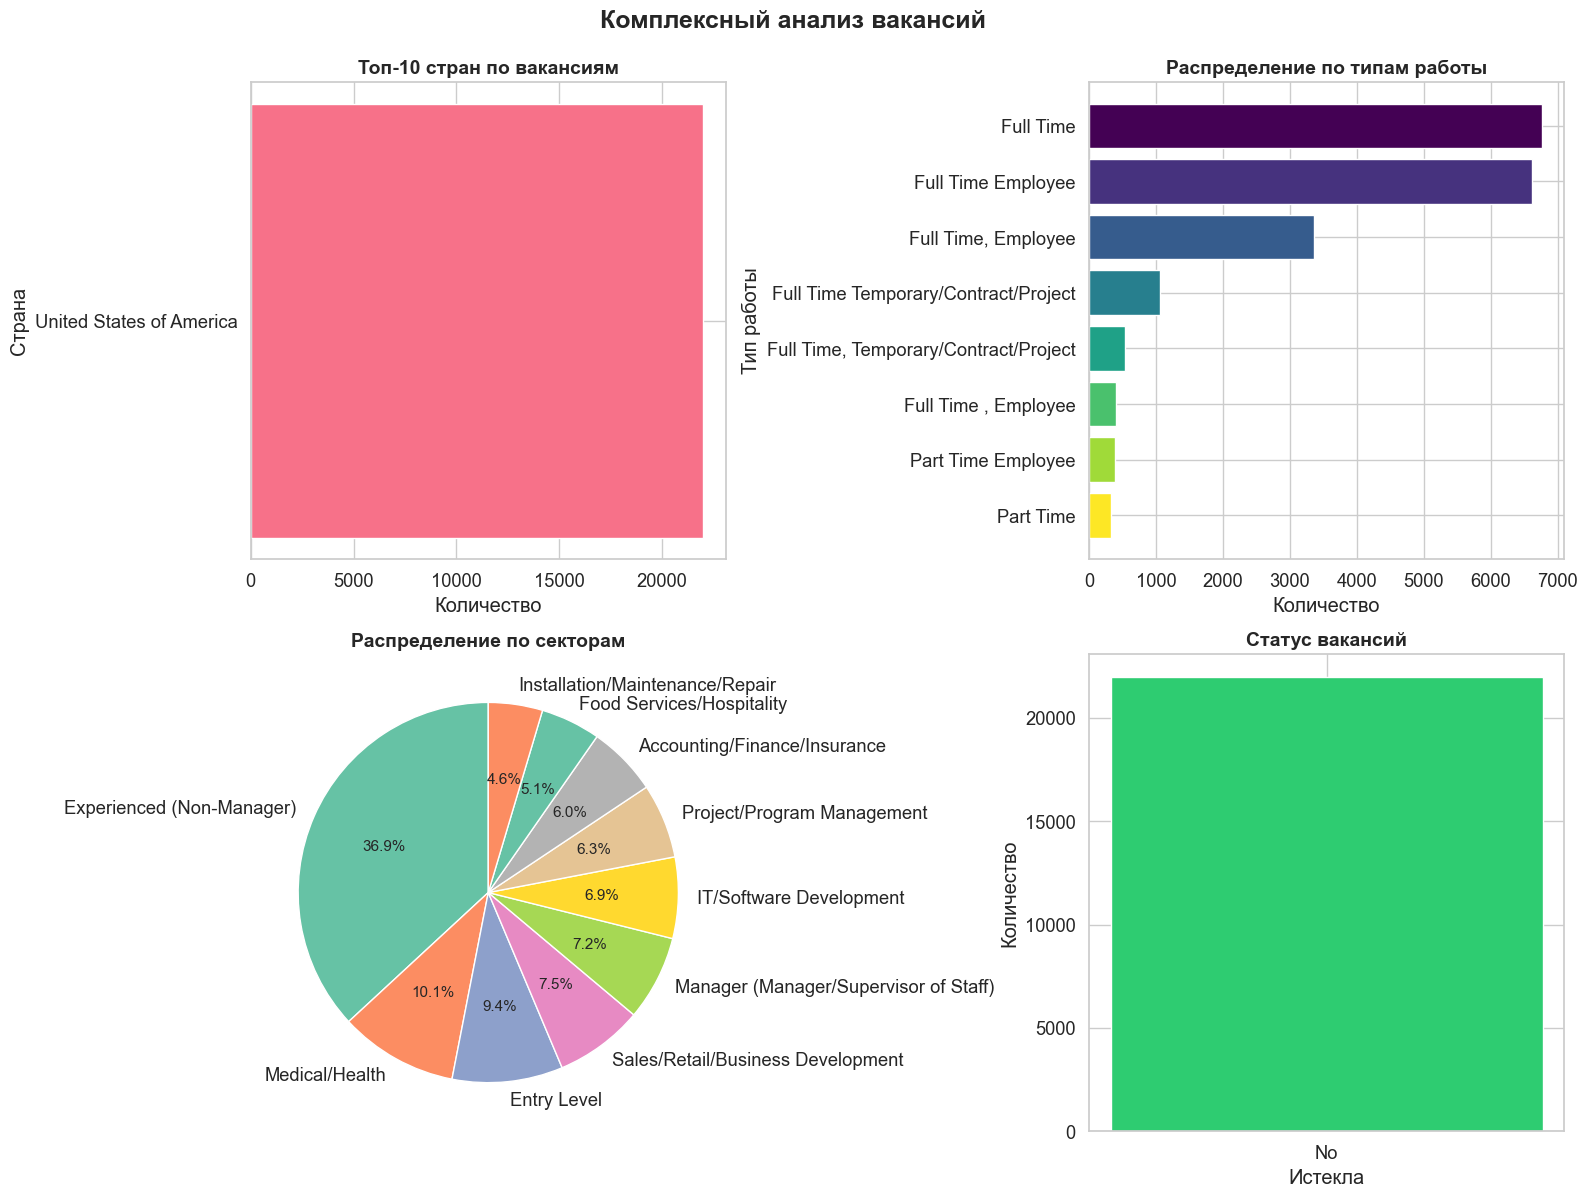

In [225]:
# Создаем сетку графиков (Grid Plot)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Комплексный анализ вакансий', fontsize=18, fontweight='bold', y=0.995)

# График 1: Топ-10 стран
if 'country' in df.columns:
    top_countries = df['country'].value_counts().head(10)
    bars = axes[0, 0].barh(range(len(top_countries)), top_countries.values, color=custom_palette[:len(top_countries)])
    axes[0, 0].set_yticks(range(len(top_countries)))
    axes[0, 0].set_yticklabels(top_countries.index)
    axes[0, 0].set_title('Топ-10 стран по вакансиям')
    axes[0, 0].set_xlabel('Количество')
    axes[0, 0].set_ylabel('Страна')
    axes[0, 0].invert_yaxis()

# График 2: Типы работы
if 'job_type' in df.columns:
    job_type_counts = df['job_type'].value_counts().head(8)
    colors_viridis = plt.cm.viridis(np.linspace(0, 1, len(job_type_counts)))
    bars = axes[0, 1].barh(range(len(job_type_counts)), job_type_counts.values, color=colors_viridis)
    axes[0, 1].set_yticks(range(len(job_type_counts)))
    axes[0, 1].set_yticklabels(job_type_counts.index)
    axes[0, 1].set_title('Распределение по типам работы')
    axes[0, 1].set_xlabel('Количество')
    axes[0, 1].set_ylabel('Тип работы')
    axes[0, 1].invert_yaxis()

# График 3: Сектора
if 'sector' in df.columns:
    sector_counts = df['sector'].value_counts().head(10)
    colors = sns.color_palette('Set2', len(sector_counts))

    axes[1, 0].pie(
        sector_counts.values,
        labels=sector_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    axes[1, 0].set_title('Распределение по секторам')

# График 4: Статус вакансий
if 'has_expired' in df.columns:
    expired_counts = df['has_expired'].value_counts()
    colors_status = ['#2ecc71', '#e74c3c'][:len(expired_counts)]
    bars = axes[1, 1].bar(range(len(expired_counts)), expired_counts.values, color=colors_status)
    axes[1, 1].set_xticks(range(len(expired_counts)))
    axes[1, 1].set_xticklabels(expired_counts.index.astype(str))
    axes[1, 1].set_title('Статус вакансий')
    axes[1, 1].set_xlabel('Истекла')
    axes[1, 1].set_ylabel('Количество')

plt.tight_layout()
plt.show()


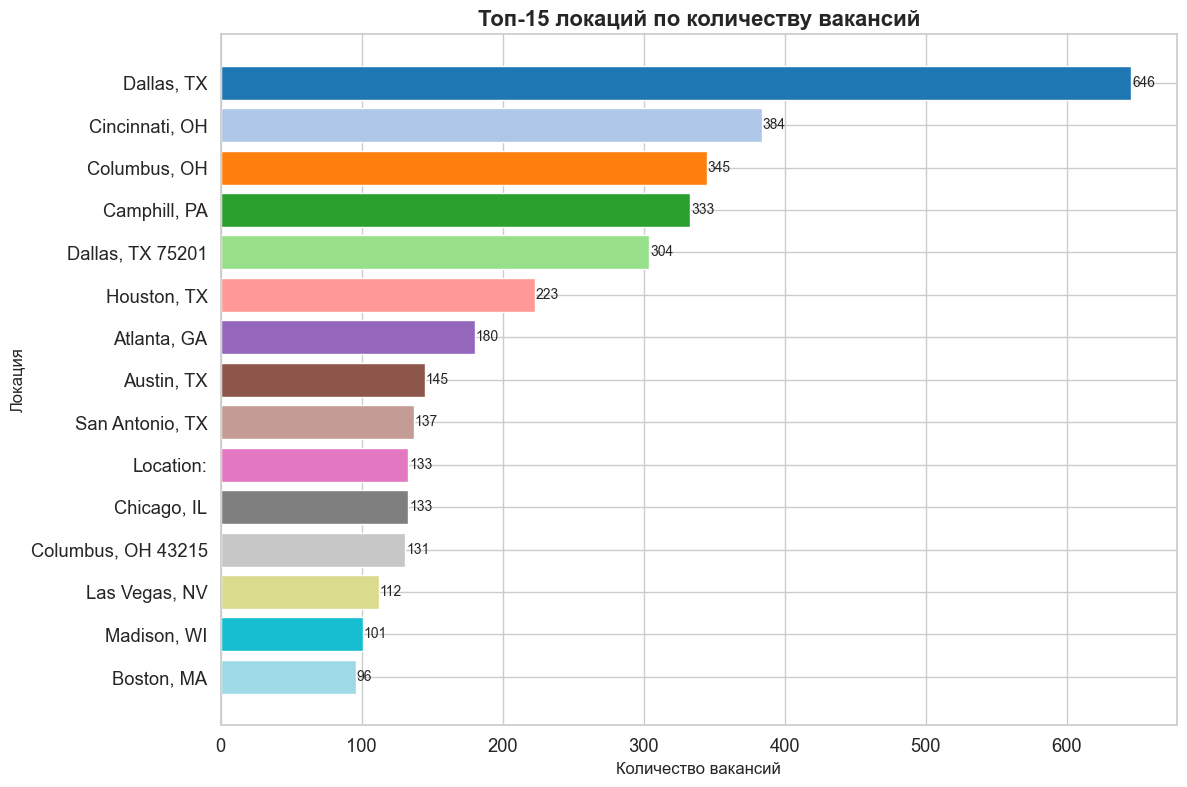

In [226]:
# Дополнительная визуализация: Топ локаций
if 'location' in df.columns:
    plt.figure(figsize=(12, 8))

    top_locations = df['location'].value_counts().head(15)
    colors = plt.cm.tab20(np.linspace(0, 1, len(top_locations)))

    plt.barh(range(len(top_locations)), top_locations.values, color=colors)
    plt.yticks(range(len(top_locations)), top_locations.index)
    plt.xlabel('Количество вакансий', fontsize=12)
    plt.ylabel('Локация', fontsize=12)
    plt.title('Топ-15 локаций по количеству вакансий', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()

    for i, v in enumerate(top_locations.values):
        plt.text(v + 0.5, i, str(v), va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Столбец 'location' не найден")


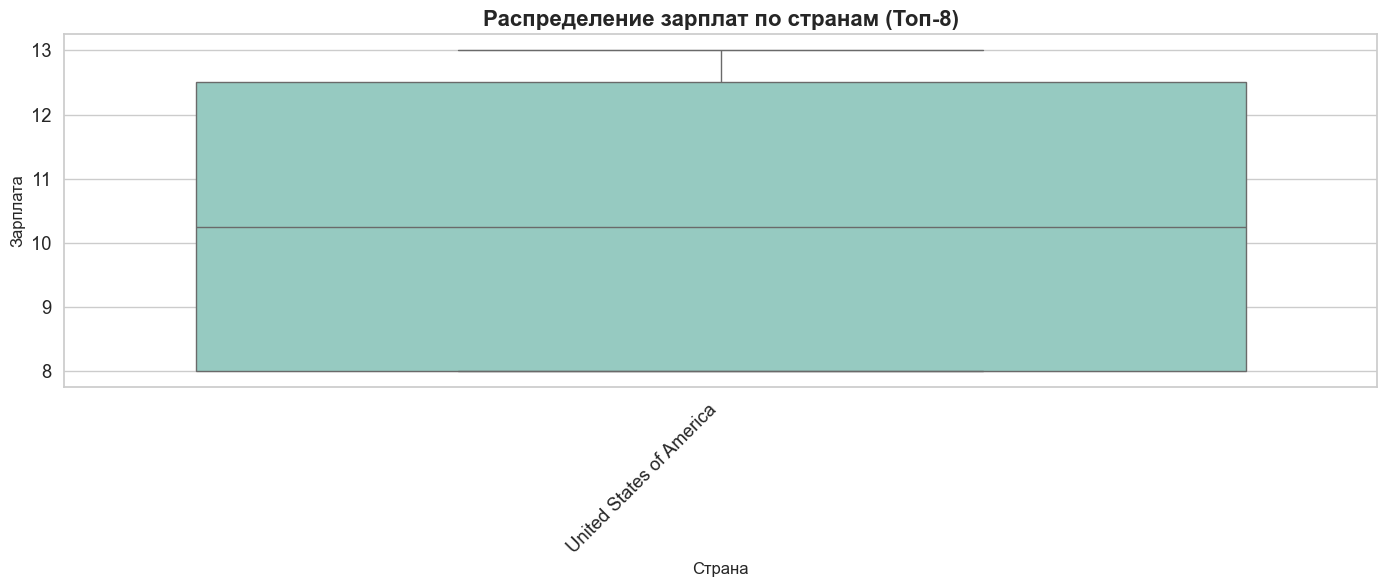

In [229]:
# Boxplot для анализа зарплат по странам (если есть данные о зарплатах)
if 'salary' in df.columns and 'country' in df.columns:
    salary_data = df[df['salary'].notna()].copy()

    if len(salary_data) > 0:
        # Берем топ-8 стран с зарплатами
        top_countries_salary = salary_data['country'].value_counts().head(8).index
        salary_filtered = salary_data[salary_data['country'].isin(top_countries_salary)]

        plt.figure(figsize=(14, 6))
        sns.boxplot(
            data=salary_filtered,
            x='country',
            y='salary',
            hue='country',
            palette='Set3',
            legend=False
        )
        plt.title('Распределение зарплат по странам (Топ-8)', fontsize=16, fontweight='bold')
        plt.xlabel('Страна', fontsize=12)
        plt.ylabel('Зарплата', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


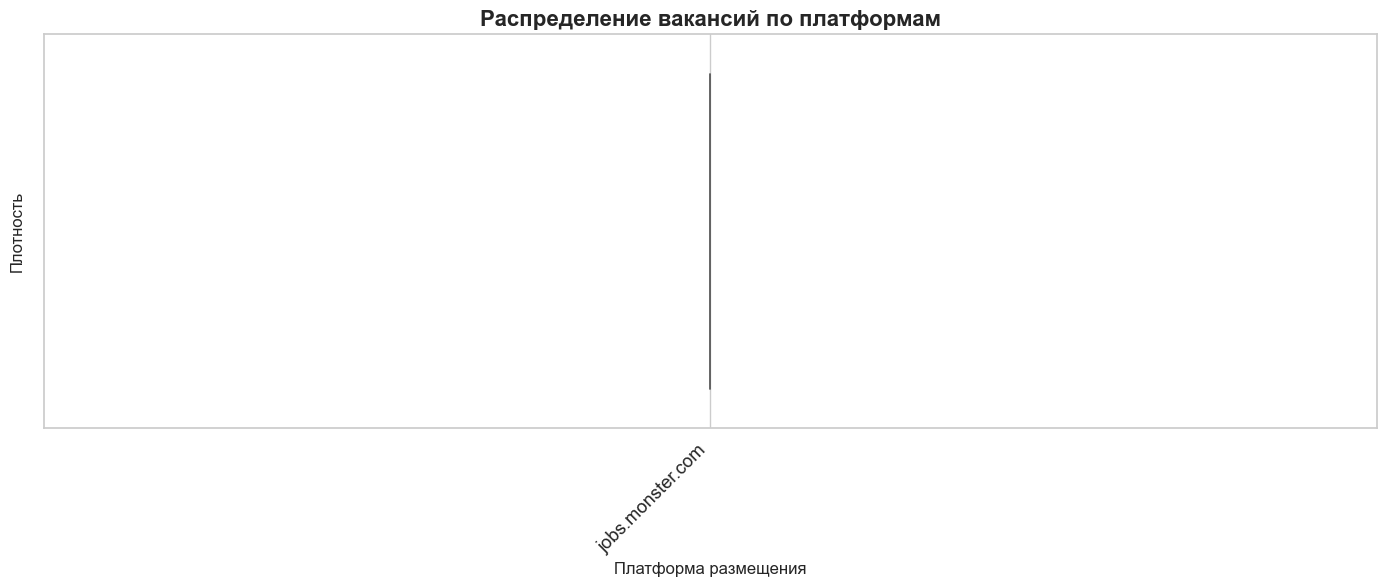

In [230]:
# Violin plot: распределение вакансий по job_board
if 'job_board' in df.columns:
    job_board_counts = df['job_board'].value_counts().head(6).index
    df_boards = df[df['job_board'].isin(job_board_counts)].copy()

    if 'country' in df.columns:
        plt.figure(figsize=(14, 6))
        sns.violinplot(
            data=df_boards,
            x='job_board',
            hue='job_board',
            palette='muted',
            legend=False
        )
        plt.title('Распределение вакансий по платформам', fontsize=16, fontweight='bold')
        plt.xlabel('Платформа размещения', fontsize=12)
        plt.ylabel('Плотность', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


### Выводы по визуализации

**Интерактивные графики (Plotly):**
- Позволяют детально изучить данные с возможностью масштабирования и фильтрации
- Особенно полезны для анализа временных рядов и иерархических данных
- Sunburst диаграмма показывает многоуровневую структуру вакансий

**Статистические графики (Seaborn):**
- Единый стиль визуализации обеспечивает профессиональный вид
- Сетка графиков позволяет сравнивать различные аспекты данных
- Boxplot и violin plot помогают выявить распределения и выбросы

**Общие инсайты:**
- Визуализация подтверждает выводы из EDA
- Графики помогают выявить скрытые паттерны в данных
- Интерактивность Plotly и детализация Seaborn дополняют друг друга
